In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from coco_stuff import COCOStuffSuper
from unet import UNet
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize, ToTensor, Resize, Lambda
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
DATA = Path("data")
IMG = DATA / "images"
IMG_TRAIN = IMG / "train2017"
IMG_VAL = IMG / "val2017"

ANNOT = DATA / "annotations"
ANNOT_TRAIN = ANNOT / "stuff_train2017.json"
ANNOT_VAL = ANNOT / "stuff_val2017.json"

In [5]:
INPUT_SIZE = 512, 512

In [6]:
image_transforms = [
    ToTensor(), 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Lambda(
        lambda img: F.interpolate(img.unsqueeze(0), INPUT_SIZE, mode="bilinear", align_corners=True).squeeze()
    )

]

mask_transforms = [
    Lambda(lambda mask: torch.FloatTensor(np.expand_dims(mask, axis=2)).permute(2, 0, 1)),
    Lambda(
        lambda mask: F.interpolate(
            mask.unsqueeze(0), INPUT_SIZE, mode="nearest"
        ).squeeze()
    ),
    Lambda(lambda mask: mask.squeeze().long())    
]

In [7]:
ds_train = COCOStuffSuper(
    images_path=IMG_TRAIN,
    annotations_json=ANNOT_TRAIN,
    transformations=image_transforms,
    target_transformations=mask_transforms
)


ds_val = COCOStuffSuper(
    images_path=IMG_VAL,
    annotations_json=ANNOT_VAL,
    transformations=image_transforms,
    target_transformations=mask_transforms
)


loading annotations into memory...
Done (t=21.70s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [8]:
ds_train.n_classes, ds_val.n_classes

(16, 16)

In [9]:
ds_val.classes_names

{0: 'building',
 1: 'ceiling',
 2: 'floor',
 3: 'food-stuff',
 4: 'furniture-stuff',
 5: 'ground',
 6: 'other',
 7: 'plant',
 8: 'raw-material',
 9: 'sky',
 10: 'solid',
 11: 'structural',
 12: 'textile',
 13: 'wall',
 14: 'water',
 15: 'window'}

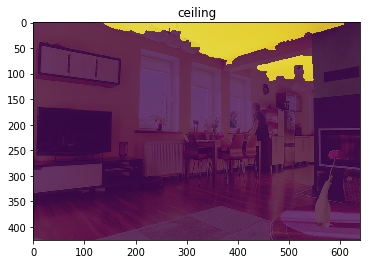

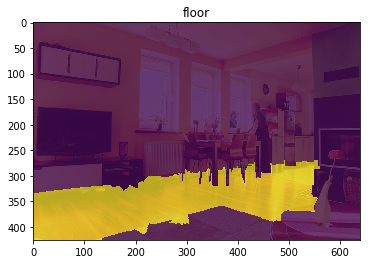

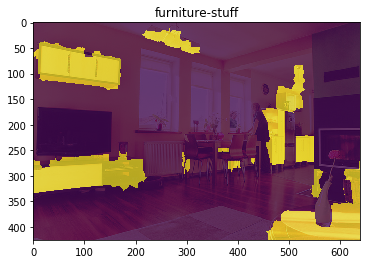

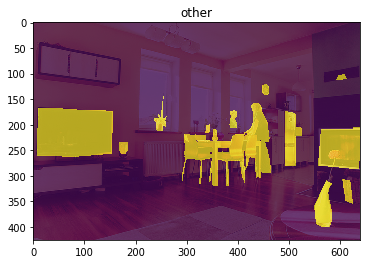

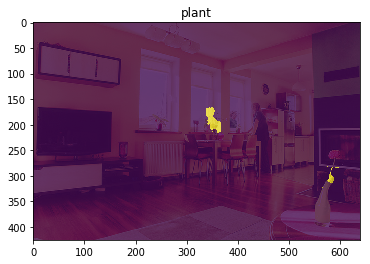

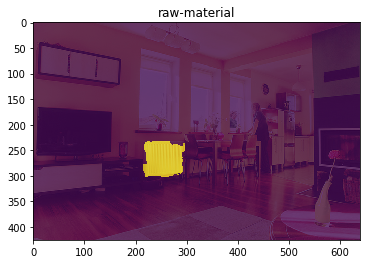

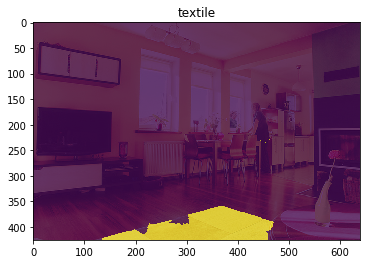

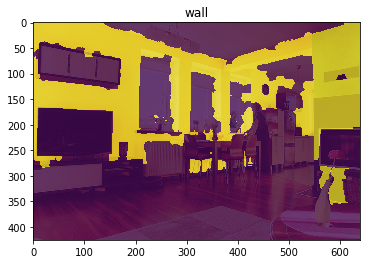

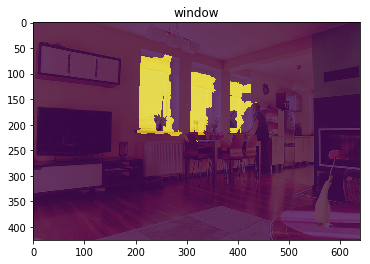

In [10]:
img, mask = ds_val.get_image_and_mask(ds_val._image_id(4145))
for i in np.unique(mask):
    cat = ds_val.classes_names[i]
    plt.title(cat)
    plt.imshow(img)
    plt.imshow(mask==i, alpha=0.7)
    plt.show()

In [11]:
loader_train = DataLoader(ds_train, batch_size=3,shuffle=True)
loader_val = DataLoader(ds_val, batch_size=1)
iter_train = iter(loader_train)
iter_val = iter(loader_val)

In [12]:
model_base = UNet(n_classes=ds_train.n_classes)

In [13]:
model = deepcopy(model_base).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(), lr=6e-4)#, weight_decay=10e-5)

In [14]:
img, mask = next(iter(loader_train))
img = img.to(device)
model(img).size()

torch.Size([3, 16, 512, 512])

In [15]:
iters = 500
epochs = 10
loss_hist = []
acc_hist = []
loss_val_hist = []
acc_val_hist = []

for i in range(iters):
    model.train()
    ls = []
    acc = []
    epochbar = tqdm(range(epochs))
    for e in epochbar:
        X_train, y_train = next(iter_train)
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)
        _, logits = torch.max(y_pred, 1)
        train_loss = loss_fn(y_pred, y_train)
        train_accuracy = (logits == y_train).sum().item() / y_train.nelement()
        ls.append(train_loss.item())
        acc.append(train_accuracy)        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        epochbar.set_description(
            f"iter: {i} | " 
            f"train_loss: {np.mean(ls)} | "
            f"train_acc: {np.mean(acc)}"
        )
    loss_hist.append(np.mean(ls))
    acc_hist.append(np.mean(acc))
    
    
    model.eval()
    ls = []
    acc = []
    with torch.no_grad():
        for _ in range(10):
            X_val, y_val = next(iter_val)
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            _, logits = torch.max(y_pred, 1)
            val_loss = loss_fn(y_pred, y_val)
            val_accuracy = (logits == y_val).sum().item() / y_val.nelement()
            ls.append(val_loss.item())
            acc.append(val_accuracy)     
        loss_val_hist.append(np.mean(ls))
        acc_val_hist.append(np.mean(acc))
        print(
                f"val_loss: {loss_val_hist[-1]} | "
                f"val_acc: {acc_val_hist[-1]}"
            )


iter: 0 | train_loss: 2.7468286037445067 | train_acc: 0.13845024108886722: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.8212061643600466 | val_acc: 0.053090667724609374


iter: 1 | train_loss: 2.6494251489639282 | train_acc: 0.285555903116862: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 4.270781421661377 | val_acc: 0.13997459411621094


iter: 2 | train_loss: 2.5121719360351564 | train_acc: 0.3304155985514323: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.7108874201774595 | val_acc: 0.1955963134765625


iter: 3 | train_loss: 2.5192538022994997 | train_acc: 0.31140530904134117: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.7005228996276855 | val_acc: 0.36255683898925783


iter: 4 | train_loss: 2.565922212600708 | train_acc: 0.37634061177571615: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.5687716364860536 | val_acc: 0.3326068878173828


iter: 5 | train_loss: 2.523330545425415 | train_acc: 0.3108957926432292: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.407557022571564 | val_acc: 0.49401168823242186


iter: 6 | train_loss: 2.394881844520569 | train_acc: 0.38191795349121094: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2788785219192507 | val_acc: 0.4324794769287109


iter: 7 | train_loss: 2.547470140457153 | train_acc: 0.31821289062499997: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.017138135433197 | val_acc: 0.5709297180175781


iter: 8 | train_loss: 2.454717516899109 | train_acc: 0.31991500854492183: 100%|██████████| 10/10 [00:33<00:00,  3.45s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.6099713325500487 | val_acc: 0.27045440673828125


iter: 9 | train_loss: 2.3954020023345945 | train_acc: 0.3800217946370442: 100%|██████████| 10/10 [00:33<00:00,  3.45s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.498010742664337 | val_acc: 0.27744293212890625


iter: 10 | train_loss: 2.3871587038040163 | train_acc: 0.31598345438639325: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.45332692861557 | val_acc: 0.3226768493652344


iter: 11 | train_loss: 2.3155457735061646 | train_acc: 0.31698036193847656: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3543943643569945 | val_acc: 0.2972431182861328


iter: 12 | train_loss: 2.345421886444092 | train_acc: 0.3051085154215495: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.168279027938843 | val_acc: 0.3860363006591797


iter: 13 | train_loss: 2.095374011993408 | train_acc: 0.36085484822591146: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.5434136986732483 | val_acc: 0.2185821533203125


iter: 14 | train_loss: 2.0953041553497314 | train_acc: 0.4063737233479817: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9621159732341766 | val_acc: 0.4378692626953125


iter: 15 | train_loss: 2.0115634322166445 | train_acc: 0.4560956319173178: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6471083402633666 | val_acc: 0.47464599609375


iter: 16 | train_loss: 2.2972954988479612 | train_acc: 0.29127820332845056: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8613918542861938 | val_acc: 0.4255855560302734


iter: 17 | train_loss: 2.016713523864746 | train_acc: 0.42510032653808594: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.689026379585266 | val_acc: 0.35752143859863283


iter: 18 | train_loss: 2.0295228481292726 | train_acc: 0.3890024820963542: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.904257357120514 | val_acc: 0.4586204528808594


iter: 19 | train_loss: 2.0342565894126894 | train_acc: 0.4183990478515625: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7649597346782684 | val_acc: 0.4425804138183594


iter: 20 | train_loss: 2.1483535408973693 | train_acc: 0.33881467183430986: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9506544589996337 | val_acc: 0.37436790466308595


iter: 21 | train_loss: 2.144662618637085 | train_acc: 0.36441434224446617: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.567057263851166 | val_acc: 0.38928375244140623


iter: 22 | train_loss: 2.1729328632354736 | train_acc: 0.3078268686930339: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.97810760140419 | val_acc: 0.46110382080078127


iter: 23 | train_loss: 1.8540934681892396 | train_acc: 0.44510421752929685: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.422148036956787 | val_acc: 0.25154991149902345


iter: 24 | train_loss: 2.1781775832176207 | train_acc: 0.32272631327311196: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0879855394363402 | val_acc: 0.32435073852539065


iter: 25 | train_loss: 2.0783718705177305 | train_acc: 0.33973846435546873: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9413868188858032 | val_acc: 0.4441078186035156


iter: 26 | train_loss: 1.8012939095497131 | train_acc: 0.4094145456949869: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.950714933872223 | val_acc: 0.3075206756591797


iter: 27 | train_loss: 1.9589520573616028 | train_acc: 0.4325279235839844: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8427523016929626 | val_acc: 0.46723251342773436


iter: 28 | train_loss: 2.215534138679504 | train_acc: 0.3507080078125: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]    
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.875294816493988 | val_acc: 0.327960205078125


iter: 29 | train_loss: 2.0756666898727416 | train_acc: 0.37293116251627606: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.99338401556015 | val_acc: 0.3888805389404297


iter: 30 | train_loss: 2.063640630245209 | train_acc: 0.3347699483235677: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9541184067726136 | val_acc: 0.3506618499755859


iter: 31 | train_loss: 2.181900155544281 | train_acc: 0.3410209655761719: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0435051202774046 | val_acc: 0.49207267761230467


iter: 32 | train_loss: 2.025906538963318 | train_acc: 0.3763707478841146: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1050494730472566 | val_acc: 0.38845672607421877


iter: 33 | train_loss: 1.9691686391830445 | train_acc: 0.39628448486328127: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7363173961639404 | val_acc: 0.4987800598144531


iter: 34 | train_loss: 2.244601249694824 | train_acc: 0.33460807800292963: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2449986696243287 | val_acc: 0.4552421569824219


iter: 35 | train_loss: 1.9565863370895387 | train_acc: 0.40613530476888016: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9055797934532166 | val_acc: 0.4611972808837891


iter: 36 | train_loss: 2.101799738407135 | train_acc: 0.3747057596842448: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.149009335041046 | val_acc: 0.37870140075683595


iter: 37 | train_loss: 2.067906618118286 | train_acc: 0.3362040201822917: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.52943217754364 | val_acc: 0.2884071350097656


iter: 38 | train_loss: 2.0598565220832823 | train_acc: 0.3945335388183594: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1800341248512267 | val_acc: 0.31432228088378905


iter: 39 | train_loss: 1.9913181900978087 | train_acc: 0.4147907257080078: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5986012011766433 | val_acc: 0.5859851837158203


iter: 40 | train_loss: 2.0697945833206175 | train_acc: 0.35963134765625004: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2031803727149963 | val_acc: 0.372802734375


iter: 41 | train_loss: 2.1936216711997987 | train_acc: 0.3618630727132161: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8261964082717896 | val_acc: 0.4666156768798828


iter: 42 | train_loss: 2.083156180381775 | train_acc: 0.33578974405924483: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1398237705230714 | val_acc: 0.3191066741943359


iter: 43 | train_loss: 1.9228168368339538 | train_acc: 0.3936239878336589: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1933420419692995 | val_acc: 0.3325038909912109


iter: 44 | train_loss: 2.1738034963607786 | train_acc: 0.34323056538899743: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0400283098220826 | val_acc: 0.48093833923339846


iter: 45 | train_loss: 2.163905441761017 | train_acc: 0.35028584798177087: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8175201654434203 | val_acc: 0.39038810729980467


iter: 46 | train_loss: 2.001381182670593 | train_acc: 0.42991282145182297: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3386855602264403 | val_acc: 0.2533008575439453


iter: 47 | train_loss: 1.9498591065406798 | train_acc: 0.4425118764241536: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1100260734558107 | val_acc: 0.39591217041015625


iter: 48 | train_loss: 2.1557801604270934 | train_acc: 0.3361295064290365: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.241856002807617 | val_acc: 0.35486640930175783


iter: 49 | train_loss: 2.012471354007721 | train_acc: 0.41939303080240886: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.193207335472107 | val_acc: 0.32848358154296875


iter: 50 | train_loss: 2.066890275478363 | train_acc: 0.4076835632324219: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9238301873207093 | val_acc: 0.32478866577148435


iter: 51 | train_loss: 1.9145055651664733 | train_acc: 0.45252011617024746: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9977277278900147 | val_acc: 0.39351882934570315


iter: 52 | train_loss: 1.9488477945327758 | train_acc: 0.47902463277180984: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9299621164798737 | val_acc: 0.38729095458984375


iter: 53 | train_loss: 2.0001804709434508 | train_acc: 0.40737063090006503: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0990818977355956 | val_acc: 0.3882442474365234


iter: 54 | train_loss: 2.0382764458656313 | train_acc: 0.37023366292317705: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.038550555706024 | val_acc: 0.4064319610595703


iter: 55 | train_loss: 1.9810091972351074 | train_acc: 0.43437728881835935: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0434231996536254 | val_acc: 0.38497581481933596


iter: 56 | train_loss: 2.0680299162864686 | train_acc: 0.35526440938313797: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.184938395023346 | val_acc: 0.20281028747558594


iter: 57 | train_loss: 2.0564911723136903 | train_acc: 0.4031302134195964: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.284302997589111 | val_acc: 0.3133258819580078


iter: 58 | train_loss: 2.075446271896362 | train_acc: 0.36324030558268233: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9605927348136902 | val_acc: 0.4063114166259766


iter: 59 | train_loss: 2.158655107021332 | train_acc: 0.341998036702474: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8986846804618835 | val_acc: 0.467425537109375


iter: 60 | train_loss: 2.013689112663269 | train_acc: 0.3872292836507161: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6040689051151276 | val_acc: 0.5321887969970703


iter: 61 | train_loss: 2.119758975505829 | train_acc: 0.3719964345296224: 100%|██████████| 10/10 [00:33<00:00,  3.45s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9540096163749694 | val_acc: 0.4157115936279297


iter: 62 | train_loss: 2.0956294417381285 | train_acc: 0.36730944315592445: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2542287826538088 | val_acc: 0.24968719482421875


iter: 63 | train_loss: 1.954842174053192 | train_acc: 0.40757420857747395: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.5305120229721068 | val_acc: 0.23666152954101563


iter: 64 | train_loss: 2.016467344760895 | train_acc: 0.3763056437174479: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.682383942604065 | val_acc: 0.4383090972900391


iter: 65 | train_loss: 2.0297116875648498 | train_acc: 0.4002213795979818: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0821560859680175 | val_acc: 0.47750167846679686


iter: 66 | train_loss: 2.10961012840271 | train_acc: 0.38460311889648435: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4861421704292297 | val_acc: 0.6627040863037109


iter: 67 | train_loss: 2.1210862398147583 | train_acc: 0.4049822489420574: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9804588437080384 | val_acc: 0.40209159851074217


iter: 68 | train_loss: 2.039994645118713 | train_acc: 0.37148462931315107: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8575905382633209 | val_acc: 0.38855438232421874


iter: 69 | train_loss: 2.1703003525733946 | train_acc: 0.3537461598714192: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0286943197250364 | val_acc: 0.4082317352294922


iter: 70 | train_loss: 1.943956232070923 | train_acc: 0.45983734130859366: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2459111273288728 | val_acc: 0.38709068298339844


iter: 71 | train_loss: 1.9493103861808776 | train_acc: 0.3968050638834636: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.272767186164856 | val_acc: 0.23382606506347656


iter: 72 | train_loss: 2.054671883583069 | train_acc: 0.4168506622314453: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.13684903383255 | val_acc: 0.34921989440917967


iter: 73 | train_loss: 1.8999140024185182 | train_acc: 0.41124636332194003: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1743616580963137 | val_acc: 0.3178718566894531


iter: 74 | train_loss: 1.8771409153938294 | train_acc: 0.41252733866373703: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8815815567970275 | val_acc: 0.46215019226074217


iter: 75 | train_loss: 1.9945415258407593 | train_acc: 0.38998146057128913: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.443792390823364 | val_acc: 0.14753799438476561


iter: 76 | train_loss: 2.0372597575187683 | train_acc: 0.3380482991536458: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.861057209968567 | val_acc: 0.31489028930664065


iter: 77 | train_loss: 2.1393707513809206 | train_acc: 0.35061136881510413: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5570038437843323 | val_acc: 0.5184200286865235


iter: 78 | train_loss: 1.9265061140060424 | train_acc: 0.4370443979899088: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7991061806678772 | val_acc: 0.43389434814453126


iter: 79 | train_loss: 1.9051742553710938 | train_acc: 0.41922454833984374: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2647426962852477 | val_acc: 0.35758018493652344


iter: 80 | train_loss: 2.1376714944839477 | train_acc: 0.38334083557128906: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7238610565662384 | val_acc: 0.4549583435058594


iter: 81 | train_loss: 2.0021533489227297 | train_acc: 0.36438051859537757: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.963862371444702 | val_acc: 0.46199951171875


iter: 82 | train_loss: 2.1229215025901795 | train_acc: 0.36883735656738287: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9141804575920105 | val_acc: 0.34807357788085935


iter: 83 | train_loss: 1.9909197568893433 | train_acc: 0.39893646240234376: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2925020098686217 | val_acc: 0.2978218078613281


iter: 84 | train_loss: 1.8935195446014403 | train_acc: 0.4160303751627604: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7585489153862 | val_acc: 0.4011802673339844


iter: 85 | train_loss: 1.890662133693695 | train_acc: 0.42938855489095057: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8748543560504913 | val_acc: 0.518365478515625


iter: 86 | train_loss: 2.0843289852142335 | train_acc: 0.36814524332682297: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9530975699424744 | val_acc: 0.4442897796630859


iter: 87 | train_loss: 2.0473103165626525 | train_acc: 0.3748748779296875: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2426825404167174 | val_acc: 0.2682220458984375


iter: 88 | train_loss: 2.0379284977912904 | train_acc: 0.3705472310384115: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2123530626297 | val_acc: 0.3409210205078125


iter: 89 | train_loss: 2.1300105690956115 | train_acc: 0.3492871602376302: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.696230709552765 | val_acc: 0.49782638549804686


iter: 90 | train_loss: 1.9771007776260376 | train_acc: 0.4304800669352213: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0853123545646666 | val_acc: 0.3869930267333984


iter: 91 | train_loss: 2.1085827708244325 | train_acc: 0.30710093180338544: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9471084833145142 | val_acc: 0.27768630981445314


iter: 92 | train_loss: 2.164543569087982 | train_acc: 0.3379041035970052: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9501088500022887 | val_acc: 0.444647216796875


iter: 93 | train_loss: 1.9037800073623656 | train_acc: 0.42438418070475264: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8461629509925843 | val_acc: 0.3932807922363281


iter: 94 | train_loss: 1.8103748679161071 | train_acc: 0.4450528462727864: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0985265493392946 | val_acc: 0.44383583068847654


iter: 95 | train_loss: 2.2774213433265684 | train_acc: 0.29142913818359373: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0956596732139587 | val_acc: 0.3922840118408203


iter: 96 | train_loss: 1.8247182726860047 | train_acc: 0.46526756286621085: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.26384015083313 | val_acc: 0.32981414794921876


iter: 97 | train_loss: 2.0900958657264708 | train_acc: 0.40837949117024747: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8642160058021546 | val_acc: 0.45756683349609373


iter: 98 | train_loss: 1.9720192074775695 | train_acc: 0.4008190155029297: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8200963377952575 | val_acc: 0.4203197479248047


iter: 99 | train_loss: 1.999868381023407 | train_acc: 0.40646031697591145: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.205706024169922 | val_acc: 0.19812698364257814


iter: 100 | train_loss: 2.0367257833480834 | train_acc: 0.38826586405436203: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9308432340621948 | val_acc: 0.3695369720458984


iter: 101 | train_loss: 1.9660632014274597 | train_acc: 0.4546031951904297: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.889425814151764 | val_acc: 0.3340129852294922


iter: 102 | train_loss: 2.003964602947235 | train_acc: 0.39406216939290367: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.88176429271698 | val_acc: 0.33742218017578124


iter: 103 | train_loss: 2.2380327224731444 | train_acc: 0.3004983266194662: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0919419527053833 | val_acc: 0.38867721557617185


iter: 104 | train_loss: 2.0019704341888427 | train_acc: 0.3701955159505208: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.285323691368103 | val_acc: 0.23895797729492188


iter: 105 | train_loss: 1.9891507744789123 | train_acc: 0.39443664550781243: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1088958859443663 | val_acc: 0.4670127868652344


iter: 106 | train_loss: 1.9332366585731506 | train_acc: 0.4334729512532552: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.034862554073334 | val_acc: 0.3251029968261719


iter: 107 | train_loss: 2.081990122795105 | train_acc: 0.35854962666829426: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9650065660476685 | val_acc: 0.4545185089111328


iter: 108 | train_loss: 1.9779343962669373 | train_acc: 0.43006350199381504: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.593115544319153 | val_acc: 0.5185012817382812


iter: 109 | train_loss: 2.08283474445343 | train_acc: 0.3892536163330078: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9341544151306151 | val_acc: 0.2754325866699219


iter: 110 | train_loss: 1.9095653295516968 | train_acc: 0.45363515218098965: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.092542576789856 | val_acc: 0.3278705596923828


iter: 111 | train_loss: 1.9165632843971252 | train_acc: 0.4374375661214193: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.597397220134735 | val_acc: 0.5941112518310547


iter: 112 | train_loss: 1.8656509160995483 | train_acc: 0.42512982686360673: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9309838652610778 | val_acc: 0.3779632568359375


iter: 113 | train_loss: 1.9790840983390807 | train_acc: 0.38197657267252605: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.148524355888367 | val_acc: 0.2754657745361328


iter: 114 | train_loss: 1.7663999915122985 | train_acc: 0.47001101175944016: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6684465825557708 | val_acc: 0.4822853088378906


iter: 115 | train_loss: 1.8799479365348817 | train_acc: 0.464953867594401: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9034554004669189 | val_acc: 0.4761302947998047


iter: 116 | train_loss: 1.847140657901764 | train_acc: 0.45568364461263017: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5624428182840346 | val_acc: 0.5489398956298828


iter: 117 | train_loss: 2.1606308579444886 | train_acc: 0.37656847635904944: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7680954217910767 | val_acc: 0.5378120422363282


iter: 118 | train_loss: 1.8407657980918883 | train_acc: 0.45288340250651044: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8518108487129212 | val_acc: 0.42488784790039064


iter: 119 | train_loss: 2.0607762932777405 | train_acc: 0.4248411814371744: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5709346532821655 | val_acc: 0.5234336853027344


iter: 120 | train_loss: 1.6889397025108337 | train_acc: 0.5212455749511719: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1383952736854552 | val_acc: 0.3266864776611328


iter: 121 | train_loss: 2.140416646003723 | train_acc: 0.34703865051269533: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.58659730553627 | val_acc: 0.5628520965576171


iter: 122 | train_loss: 1.937426245212555 | train_acc: 0.4244341532389323: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0693359971046448 | val_acc: 0.47098731994628906


iter: 123 | train_loss: 1.9221577763557434 | train_acc: 0.44523251851399737: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.028902554512024 | val_acc: 0.4246711730957031


iter: 124 | train_loss: 2.000329613685608 | train_acc: 0.367056147257487: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.098507285118103 | val_acc: 0.3939945220947266


iter: 125 | train_loss: 2.036858630180359 | train_acc: 0.3820664723714193: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8781458497047425 | val_acc: 0.4182750701904297


iter: 126 | train_loss: 1.9437442302703858 | train_acc: 0.4353767395019531: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9025565147399903 | val_acc: 0.4225315093994141


iter: 127 | train_loss: 2.0156657695770264 | train_acc: 0.4184547424316406: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4744280219078063 | val_acc: 0.19340591430664061


iter: 128 | train_loss: 1.9235038042068482 | train_acc: 0.44639307657877597: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.506773865222931 | val_acc: 0.3232002258300781


iter: 129 | train_loss: 2.04578298330307 | train_acc: 0.36789894104003906: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9123818635940553 | val_acc: 0.4564182281494141


iter: 130 | train_loss: 1.9038776278495788 | train_acc: 0.4521219889322917: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1907184600830076 | val_acc: 0.29243316650390627


iter: 131 | train_loss: 2.0742977380752565 | train_acc: 0.4123870849609375: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7384026646614075 | val_acc: 0.4622833251953125


iter: 132 | train_loss: 2.0445483565330504 | train_acc: 0.38413391113281253: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6740705013275146 | val_acc: 0.4760326385498047


iter: 133 | train_loss: 2.0321372985839843 | train_acc: 0.3649280548095703: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.342128723859787 | val_acc: 0.5106357574462891


iter: 134 | train_loss: 1.9778784275054933 | train_acc: 0.41832122802734373: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.657932186126709 | val_acc: 0.5645946502685547


iter: 135 | train_loss: 1.8426008343696594 | train_acc: 0.46446075439453116: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0516388416290283 | val_acc: 0.3137939453125


iter: 136 | train_loss: 2.1289737701416014 | train_acc: 0.35116119384765626: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0994643449783323 | val_acc: 0.38344764709472656


iter: 137 | train_loss: 2.052297532558441 | train_acc: 0.36691932678222655: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3851374864578245 | val_acc: 0.39092063903808594


iter: 138 | train_loss: 1.8560503363609313 | train_acc: 0.4880442301432292: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1869919180870054 | val_acc: 0.37304039001464845


iter: 139 | train_loss: 1.7984217286109925 | train_acc: 0.4632853190104166: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2061573386192324 | val_acc: 0.2818138122558594


iter: 140 | train_loss: 1.718393576145172 | train_acc: 0.5394680023193359: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.63628751039505 | val_acc: 0.5414970397949219


iter: 141 | train_loss: 1.9292415261268616 | train_acc: 0.42177174886067714: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.775916087627411 | val_acc: 0.48525466918945315


iter: 142 | train_loss: 2.208872044086456 | train_acc: 0.3232597351074219: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0352123856544493 | val_acc: 0.3639369964599609


iter: 143 | train_loss: 2.005711054801941 | train_acc: 0.41725832621256514: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8508703589439393 | val_acc: 0.48473968505859377


iter: 144 | train_loss: 1.803888201713562 | train_acc: 0.46519025166829425: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.169994902610779 | val_acc: 0.3519763946533203


iter: 145 | train_loss: 1.8536085128784179 | train_acc: 0.4262685139973958: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.222314250469208 | val_acc: 0.25154457092285154


iter: 146 | train_loss: 2.0165923714637755 | train_acc: 0.37540829976399737: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0486019611358643 | val_acc: 0.35800743103027344


iter: 147 | train_loss: 2.0083618760108948 | train_acc: 0.4237406412760417: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8790090203285217 | val_acc: 0.42054443359375


iter: 148 | train_loss: 1.981817889213562 | train_acc: 0.41069895426432285: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1580348014831543 | val_acc: 0.46154098510742186


iter: 149 | train_loss: 2.1058170199394226 | train_acc: 0.3444829305013021: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.115571141242981 | val_acc: 0.33556671142578126


iter: 150 | train_loss: 2.004996383190155 | train_acc: 0.4291084289550781: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9743363738059998 | val_acc: 0.4671657562255859


iter: 151 | train_loss: 2.066391921043396 | train_acc: 0.4040365854899089: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.266197311878204 | val_acc: 0.3490001678466797


iter: 152 | train_loss: 1.9067864656448363 | train_acc: 0.37447967529296877: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1012407898902894 | val_acc: 0.29910621643066404


iter: 153 | train_loss: 1.9632460474967957 | train_acc: 0.4103584289550781: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9127459406852723 | val_acc: 0.48131370544433594


iter: 154 | train_loss: 2.1295197367668153 | train_acc: 0.3586186726888021: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8780689477920531 | val_acc: 0.3564456939697266


iter: 155 | train_loss: 1.994051730632782 | train_acc: 0.39231007893880204: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7730584502220155 | val_acc: 0.538943862915039


iter: 156 | train_loss: 2.0893331170082092 | train_acc: 0.36904106140136717: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9413861274719237 | val_acc: 0.41282005310058595


iter: 157 | train_loss: 1.9236664295196533 | train_acc: 0.4550537109375: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]   
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.107795810699463 | val_acc: 0.37697715759277345


iter: 158 | train_loss: 1.8350000619888305 | train_acc: 0.4429787953694662: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4174033939838409 | val_acc: 0.6455059051513672


iter: 159 | train_loss: 1.8811304688453674 | train_acc: 0.44020436604817714: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.518229204416275 | val_acc: 0.577761459350586


iter: 160 | train_loss: 1.7739496231079102 | train_acc: 0.4430981953938802: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.767927086353302 | val_acc: 0.5220550537109375


iter: 161 | train_loss: 1.7128680348396301 | train_acc: 0.5175787607828777: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1061961174011232 | val_acc: 0.279534912109375


iter: 162 | train_loss: 1.8180325269699096 | train_acc: 0.48514633178710936: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3579548716545107 | val_acc: 0.3417182922363281


iter: 163 | train_loss: 2.1074197053909303 | train_acc: 0.33386332194010415: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8743994116783143 | val_acc: 0.43024253845214844


iter: 164 | train_loss: 1.8003230810165405 | train_acc: 0.5060242970784505: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.098482131958008 | val_acc: 0.37921867370605467


iter: 165 | train_loss: 1.9244905829429626 | train_acc: 0.4423347473144531: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4649741649627686 | val_acc: 0.3152595520019531


iter: 166 | train_loss: 2.0936501741409304 | train_acc: 0.3993212381998698: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9842211484909058 | val_acc: 0.33047637939453123


iter: 167 | train_loss: 2.0563002228736877 | train_acc: 0.4253130594889322: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1253974795341493 | val_acc: 0.3665515899658203


iter: 168 | train_loss: 2.105328583717346 | train_acc: 0.34909998575846357: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9369852185249328 | val_acc: 0.44320030212402345


iter: 169 | train_loss: 2.0138275265693664 | train_acc: 0.3801431020100911: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.070825183391571 | val_acc: 0.4160797119140625


iter: 170 | train_loss: 1.976531410217285 | train_acc: 0.406555430094401: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7761418581008912 | val_acc: 0.5585681915283203


iter: 171 | train_loss: 2.0965508937835695 | train_acc: 0.40522715250651037: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.577692013978958 | val_acc: 0.5961605072021484


iter: 172 | train_loss: 1.9574045658111572 | train_acc: 0.4291248321533203: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.083758795261383 | val_acc: 0.39347076416015625


iter: 173 | train_loss: 1.8925286293029786 | train_acc: 0.3993349711100261: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9957034170627594 | val_acc: 0.4010047912597656


iter: 174 | train_loss: 1.8753209471702577 | train_acc: 0.42604624430338534: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.828007411956787 | val_acc: 0.4264118194580078


iter: 175 | train_loss: 2.025245797634125 | train_acc: 0.39325281778971355: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8572418570518494 | val_acc: 0.39986572265625


iter: 176 | train_loss: 1.8433953285217286 | train_acc: 0.4495147705078125: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.071739947795868 | val_acc: 0.42580184936523435


iter: 177 | train_loss: 1.8850185036659242 | train_acc: 0.44069073994954433: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1511749505996702 | val_acc: 0.3475776672363281


iter: 178 | train_loss: 1.9931923270225524 | train_acc: 0.41361058553059893: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.222683000564575 | val_acc: 0.2254364013671875


iter: 179 | train_loss: 2.1047796607017517 | train_acc: 0.34804623921712236: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0127638936042787 | val_acc: 0.3013496398925781


iter: 180 | train_loss: 1.8531952261924745 | train_acc: 0.45147158304850254: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8107688844203949 | val_acc: 0.4867137908935547


iter: 181 | train_loss: 2.029702603816986 | train_acc: 0.4184759775797525: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.31024831533432 | val_acc: 0.36129302978515626


iter: 182 | train_loss: 1.9231046557426452 | train_acc: 0.4018428802490234: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7814480304718017 | val_acc: 0.4942005157470703


iter: 183 | train_loss: 1.8778425931930542 | train_acc: 0.44906565348307287: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4682260632514954 | val_acc: 0.6332256317138671


iter: 184 | train_loss: 2.068165647983551 | train_acc: 0.41552111307779943: 100%|██████████| 10/10 [00:33<00:00,  3.45s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6135628938674926 | val_acc: 0.5476070404052734


iter: 185 | train_loss: 2.0367282748222353 | train_acc: 0.4113897959391276: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.559371393918991 | val_acc: 0.6155975341796875


iter: 186 | train_loss: 1.9601585268974304 | train_acc: 0.43726361592610685: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.233107101917267 | val_acc: 0.23681602478027344


iter: 187 | train_loss: 1.8652676463127136 | train_acc: 0.41390940348307287: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.911169159412384 | val_acc: 0.3668651580810547


iter: 188 | train_loss: 1.908701729774475 | train_acc: 0.4249867757161458: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.497951090335846 | val_acc: 0.2381969451904297


iter: 189 | train_loss: 1.8596191167831422 | train_acc: 0.42752749125162753: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.08297575712204 | val_acc: 0.44214630126953125


iter: 190 | train_loss: 1.9506800413131713 | train_acc: 0.4501341501871744: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0059489369392396 | val_acc: 0.29300270080566404


iter: 191 | train_loss: 1.9126894354820252 | train_acc: 0.4333924611409506: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1596521615982054 | val_acc: 0.2698219299316406


iter: 192 | train_loss: 1.9334372520446776 | train_acc: 0.44161376953125: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9712084114551545 | val_acc: 0.3584922790527344


iter: 193 | train_loss: 1.8774373292922975 | train_acc: 0.4414338429768881: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8388927698135376 | val_acc: 0.3784641265869141


iter: 194 | train_loss: 2.009121572971344 | train_acc: 0.3985416412353515: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7826130867004395 | val_acc: 0.5421638488769531


iter: 195 | train_loss: 1.8158869981765746 | train_acc: 0.4841921488444011: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.775163072347641 | val_acc: 0.5026527404785156


iter: 196 | train_loss: 2.0457355260848997 | train_acc: 0.4138753255208334: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3652353286743164 | val_acc: 0.3690471649169922


iter: 197 | train_loss: 1.9544204592704773 | train_acc: 0.374066162109375: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4305081367492676 | val_acc: 0.600430679321289


iter: 198 | train_loss: 1.9001841306686402 | train_acc: 0.44709154764811193: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.966338539123535 | val_acc: 0.3296855926513672


iter: 199 | train_loss: 1.8241208910942077 | train_acc: 0.4882780710856121: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.017066550254822 | val_acc: 0.3595489501953125


iter: 200 | train_loss: 1.8825126051902772 | train_acc: 0.4217632293701172: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.78905109167099 | val_acc: 0.48802719116210935


iter: 201 | train_loss: 1.9367294669151307 | train_acc: 0.4041164398193359: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1906122088432314 | val_acc: 0.34707489013671877


iter: 202 | train_loss: 1.9457887530326843 | train_acc: 0.43544960021972656: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.157497799396515 | val_acc: 0.37464218139648436


iter: 203 | train_loss: 2.213431477546692 | train_acc: 0.3452747344970703: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2137205839157104 | val_acc: 0.32855949401855467


iter: 204 | train_loss: 2.0802271008491515 | train_acc: 0.3756638844807943: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.123374342918396 | val_acc: 0.3211639404296875


iter: 205 | train_loss: 2.036179614067078 | train_acc: 0.37939656575520836: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2757850646972657 | val_acc: 0.3000663757324219


iter: 206 | train_loss: 1.8443481087684632 | train_acc: 0.4474295298258464: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6152106404304505 | val_acc: 0.5736763000488281


iter: 207 | train_loss: 1.9538026809692384 | train_acc: 0.40837961832682296: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9934331774711609 | val_acc: 0.4748973846435547


iter: 208 | train_loss: 1.9613938689231873 | train_acc: 0.3744427998860677: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8788828253746033 | val_acc: 0.48685264587402344


iter: 209 | train_loss: 1.8952091693878175 | train_acc: 0.42795855204264327: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.918143528699875 | val_acc: 0.5087085723876953


iter: 210 | train_loss: 1.9234782457351685 | train_acc: 0.42702077229817714: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.311138880252838 | val_acc: 0.6265525817871094


iter: 211 | train_loss: 1.787896203994751 | train_acc: 0.4889817555745443: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.332355189323425 | val_acc: 0.3042762756347656


iter: 212 | train_loss: 1.877940821647644 | train_acc: 0.48772633870442705: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1910416305065157 | val_acc: 0.4041900634765625


iter: 213 | train_loss: 1.9927195191383362 | train_acc: 0.393499755859375: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9959150195121764 | val_acc: 0.4630886077880859


iter: 214 | train_loss: 1.8192628383636475 | train_acc: 0.46433054606119784: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9150467038154602 | val_acc: 0.40438499450683596


iter: 215 | train_loss: 2.064812219142914 | train_acc: 0.3713555653889974: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.243363231420517 | val_acc: 0.4161285400390625


iter: 216 | train_loss: 1.8538392186164856 | train_acc: 0.4540749867757162: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0834918200969694 | val_acc: 0.3855113983154297


iter: 217 | train_loss: 1.9990841507911683 | train_acc: 0.3611640930175781: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0459288597106933 | val_acc: 0.42424888610839845


iter: 218 | train_loss: 2.053703451156616 | train_acc: 0.35970853169759115: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9354498863220215 | val_acc: 0.39948310852050783


iter: 219 | train_loss: 1.8388495445251465 | train_acc: 0.41668650309244787: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8817546606063842 | val_acc: 0.33504905700683596


iter: 220 | train_loss: 1.8201649188995361 | train_acc: 0.4780344645182293: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.066747784614563 | val_acc: 0.3832664489746094


iter: 221 | train_loss: 1.9645434737205505 | train_acc: 0.4468536376953126: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9638481974601745 | val_acc: 0.43349037170410154


iter: 222 | train_loss: 1.6873311400413513 | train_acc: 0.5576815287272134: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5127538949251176 | val_acc: 0.5922550201416016


iter: 223 | train_loss: 2.028878128528595 | train_acc: 0.41998850504557295: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.114118790626526 | val_acc: 0.3656726837158203


iter: 224 | train_loss: 1.8297872066497802 | train_acc: 0.4839908599853516: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4131662964820864 | val_acc: 0.24915580749511718


iter: 225 | train_loss: 1.957438325881958 | train_acc: 0.434063720703125: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.124964451789856 | val_acc: 0.36537895202636717


iter: 226 | train_loss: 1.9208794355392456 | train_acc: 0.43852895100911454: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4237701654434205 | val_acc: 0.36692161560058595


iter: 227 | train_loss: 1.8763211727142335 | train_acc: 0.4477671305338542: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8830500721931458 | val_acc: 0.43225746154785155


iter: 228 | train_loss: 1.8841582655906677 | train_acc: 0.45292905171712244: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8510029435157775 | val_acc: 0.40108261108398435


iter: 229 | train_loss: 1.8790348410606383 | train_acc: 0.4599581400553386: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8803303480148315 | val_acc: 0.3819255828857422


iter: 230 | train_loss: 1.9688270688056946 | train_acc: 0.38230539957682286: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0462644577026365 | val_acc: 0.3448028564453125


iter: 231 | train_loss: 1.9487262964248657 | train_acc: 0.38958740234375006: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8263174295425415 | val_acc: 0.4248779296875


iter: 232 | train_loss: 1.810468590259552 | train_acc: 0.4848445892333985: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0403923273086546 | val_acc: 0.4415412902832031


iter: 233 | train_loss: 1.9047473907470702 | train_acc: 0.46585922241210936: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8548425555229187 | val_acc: 0.551395034790039


iter: 234 | train_loss: 2.0982192516326905 | train_acc: 0.38247706095377604: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7062726259231566 | val_acc: 0.5441192626953125


iter: 235 | train_loss: 1.8416473269462585 | train_acc: 0.4242668151855469: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5351186752319337 | val_acc: 0.5723018646240234


iter: 236 | train_loss: 1.915181577205658 | train_acc: 0.43816579182942716: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.79701908826828 | val_acc: 0.40628204345703123


iter: 237 | train_loss: 2.063369560241699 | train_acc: 0.3835076649983724: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9006227493286132 | val_acc: 0.45286102294921876


iter: 238 | train_loss: 1.9466946125030518 | train_acc: 0.43171030680338546: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8195480227470398 | val_acc: 0.4331378936767578


iter: 239 | train_loss: 1.972341775894165 | train_acc: 0.41982421875: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]      
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.794685387611389 | val_acc: 0.5169872283935547


iter: 240 | train_loss: 1.9114937782287598 | train_acc: 0.4474966684977214: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8637108206748962 | val_acc: 0.4997711181640625


iter: 241 | train_loss: 1.8472331523895265 | train_acc: 0.46854070027669276: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0198503375053405 | val_acc: 0.42531509399414064


iter: 242 | train_loss: 1.793787908554077 | train_acc: 0.42765668233235676: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9996859312057496 | val_acc: 0.3594676971435547


iter: 243 | train_loss: 1.802660381793976 | train_acc: 0.4800577799479166: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6458258926868439 | val_acc: 0.5542514801025391


iter: 244 | train_loss: 1.851628565788269 | train_acc: 0.43349164326985673: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.570963716506958 | val_acc: 0.5129550933837891


iter: 245 | train_loss: 1.9253026723861695 | train_acc: 0.44552014668782547: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6275162160396577 | val_acc: 0.5292457580566406


iter: 246 | train_loss: 1.8187567710876464 | train_acc: 0.4530782063802084: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.736515724658966 | val_acc: 0.47498626708984376


iter: 247 | train_loss: 1.7671273708343507 | train_acc: 0.4646322886149088: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.937872540950775 | val_acc: 0.4495887756347656


iter: 248 | train_loss: 2.0077309608459473 | train_acc: 0.38620643615722655: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9982051372528076 | val_acc: 0.37901992797851564


iter: 249 | train_loss: 1.9172855734825134 | train_acc: 0.44261334737141933: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.3699382066726686 | val_acc: 0.1589519500732422


iter: 250 | train_loss: 2.002259302139282 | train_acc: 0.4049400329589844: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2629542350769043 | val_acc: 0.26647605895996096


iter: 251 | train_loss: 2.0969239592552187 | train_acc: 0.3902058919270833: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.771409285068512 | val_acc: 0.4551399230957031


iter: 252 | train_loss: 1.9895628094673157 | train_acc: 0.39867006937662763: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.746471917629242 | val_acc: 0.5719474792480469


iter: 253 | train_loss: 1.844236135482788 | train_acc: 0.4685630798339844: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.192843163013458 | val_acc: 0.30471000671386717


iter: 254 | train_loss: 1.7273238062858582 | train_acc: 0.5219470977783203: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4645366311073302 | val_acc: 0.32283172607421873


iter: 255 | train_loss: 1.9488053798675538 | train_acc: 0.4401075998942058: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.2975500643253326 | val_acc: 0.6012729644775391


iter: 256 | train_loss: 1.8731460690498352 | train_acc: 0.4507113138834636: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7932786107063294 | val_acc: 0.45994110107421876


iter: 257 | train_loss: 1.7836023807525634 | train_acc: 0.4727739969889323: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4456963658332824 | val_acc: 0.6203433990478515


iter: 258 | train_loss: 1.8090082168579102 | train_acc: 0.45445518493652354: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9314121842384337 | val_acc: 0.4074398040771484


iter: 259 | train_loss: 1.7814929604530334 | train_acc: 0.4324932098388672: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.882390308380127 | val_acc: 0.44471893310546873


iter: 260 | train_loss: 1.9701042175292969 | train_acc: 0.43023338317871096: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8405038356781005 | val_acc: 0.48789405822753906


iter: 261 | train_loss: 1.8468405604362488 | train_acc: 0.4427022298177083: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.4165629208087922 | val_acc: 0.601474380493164


iter: 262 | train_loss: 2.1322938203811646 | train_acc: 0.36804962158203125: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2137818694114686 | val_acc: 0.37906570434570314


iter: 263 | train_loss: 1.961989176273346 | train_acc: 0.3991377512613933: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0419219970703124 | val_acc: 0.46214942932128905


iter: 264 | train_loss: 1.8552594423294066 | train_acc: 0.43324521382649744: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0902858138084413 | val_acc: 0.3092350006103516


iter: 265 | train_loss: 1.715475571155548 | train_acc: 0.5106239318847656: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9160834312438966 | val_acc: 0.38922271728515623


iter: 266 | train_loss: 1.7683006167411803 | train_acc: 0.45862172444661464: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0915765523910523 | val_acc: 0.41306266784667967


iter: 267 | train_loss: 1.817207968235016 | train_acc: 0.46873830159505214: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1262094974517822 | val_acc: 0.3590839385986328


iter: 268 | train_loss: 1.9218538761138917 | train_acc: 0.42238591512044277: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5863296031951903 | val_acc: 0.49638671875


iter: 269 | train_loss: 1.9119548678398133 | train_acc: 0.4202919006347656: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.85482017993927 | val_acc: 0.5202266693115234


iter: 270 | train_loss: 1.8993748307228089 | train_acc: 0.4250188191731771: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.849210548400879 | val_acc: 0.42776947021484374


iter: 271 | train_loss: 1.7641083240509032 | train_acc: 0.43678131103515627: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6457279682159425 | val_acc: 0.5243984222412109


iter: 272 | train_loss: 1.7549337148666382 | train_acc: 0.47042706807454426: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8843188881874084 | val_acc: 0.41058998107910155


iter: 273 | train_loss: 1.9031979203224183 | train_acc: 0.46589533487955725: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7427170395851135 | val_acc: 0.47414703369140626


iter: 274 | train_loss: 1.673308825492859 | train_acc: 0.4872234344482422: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7373692572116852 | val_acc: 0.4196971893310547


iter: 275 | train_loss: 1.9226428508758544 | train_acc: 0.4296545664469401: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9236398458480835 | val_acc: 0.42720184326171873


iter: 276 | train_loss: 1.937326395511627 | train_acc: 0.4278285980224609: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4878912925720216 | val_acc: 0.22167892456054689


iter: 277 | train_loss: 2.0610025405883787 | train_acc: 0.3964260101318359: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0676119208335875 | val_acc: 0.4213665008544922


iter: 278 | train_loss: 1.695404016971588 | train_acc: 0.4865834554036458: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9219717800617218 | val_acc: 0.4488636016845703


iter: 279 | train_loss: 1.9129196763038636 | train_acc: 0.4558719635009766: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.938597846031189 | val_acc: 0.4419395446777344


iter: 280 | train_loss: 1.9274436593055726 | train_acc: 0.4407843271891275: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.956110143661499 | val_acc: 0.38729400634765626


iter: 281 | train_loss: 1.7905966997146607 | train_acc: 0.4384315490722656: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.143918991088867 | val_acc: 0.3836986541748047


iter: 282 | train_loss: 2.0098400354385375 | train_acc: 0.40761680603027345: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0880611300468446 | val_acc: 0.4283283233642578


iter: 283 | train_loss: 1.8835758566856384 | train_acc: 0.44149169921875: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0918606877326966 | val_acc: 0.32802696228027345


iter: 284 | train_loss: 1.9083720088005065 | train_acc: 0.4122647603352864: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7608303070068358 | val_acc: 0.49527587890625


iter: 285 | train_loss: 1.7353259801864624 | train_acc: 0.49186579386393225: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9133240461349488 | val_acc: 0.40637359619140623


iter: 286 | train_loss: 1.8974149823188782 | train_acc: 0.3970274607340495: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9984875977039338 | val_acc: 0.43996429443359375


iter: 287 | train_loss: 1.7071312308311462 | train_acc: 0.5085662841796876: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6268404364585876 | val_acc: 0.5498783111572265


iter: 288 | train_loss: 2.091872215270996 | train_acc: 0.3923421223958333: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7415622234344483 | val_acc: 0.5067340850830078


iter: 289 | train_loss: 1.8401505470275878 | train_acc: 0.46408958435058584: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.365215849876404 | val_acc: 0.3085136413574219


iter: 290 | train_loss: 1.7005720376968383 | train_acc: 0.5043031056722005: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1362098097801208 | val_acc: 0.333642578125


iter: 291 | train_loss: 1.7117895007133483 | train_acc: 0.5327163696289062: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.2772064447402953 | val_acc: 0.6524971008300782


iter: 292 | train_loss: 2.0902737617492675 | train_acc: 0.4087992350260417: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.13054883480072 | val_acc: 0.38816032409667967


iter: 293 | train_loss: 1.9508123874664307 | train_acc: 0.4359175364176432: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4832369685173035 | val_acc: 0.26096382141113283


iter: 294 | train_loss: 1.9251873731613158 | train_acc: 0.44058977762858076: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0624646663665773 | val_acc: 0.39366874694824217


iter: 295 | train_loss: 1.829836869239807 | train_acc: 0.45567385355631507: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 5.803507643938064 | val_acc: 0.34265480041503904


iter: 296 | train_loss: 1.8255010962486267 | train_acc: 0.4622666676839192: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5715824246406556 | val_acc: 0.5831523895263672


iter: 297 | train_loss: 1.7147209167480468 | train_acc: 0.4981544494628906: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9815882444381714 | val_acc: 0.44971046447753904


iter: 298 | train_loss: 1.7590811848640442 | train_acc: 0.4921834309895834: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7075031280517579 | val_acc: 0.5079742431640625


iter: 299 | train_loss: 1.7864948451519012 | train_acc: 0.4876033782958985: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0431573033332824 | val_acc: 0.4018665313720703


iter: 300 | train_loss: 2.0143259048461912 | train_acc: 0.39878120422363283: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5885369062423706 | val_acc: 0.5159843444824219


iter: 301 | train_loss: 1.6925207376480103 | train_acc: 0.52450803120931: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6145376980304718 | val_acc: 0.587322998046875


iter: 302 | train_loss: 1.9964868307113648 | train_acc: 0.42407582600911464: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.84883154630661 | val_acc: 0.42446746826171877


iter: 303 | train_loss: 1.9559211492538453 | train_acc: 0.4055146535237631: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1469319581985475 | val_acc: 0.41690673828125


iter: 304 | train_loss: 1.9936146020889283 | train_acc: 0.3797734578450521: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0681811809539794 | val_acc: 0.40697021484375


iter: 305 | train_loss: 1.7870524048805236 | train_acc: 0.4555819193522136: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6733526289463043 | val_acc: 0.5307476043701171


iter: 306 | train_loss: 1.8653775095939635 | train_acc: 0.44208641052246084: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1528191566467285 | val_acc: 0.3335254669189453


iter: 307 | train_loss: 1.5484673023223876 | train_acc: 0.5566914876302083: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0115023612976075 | val_acc: 0.3472114562988281


iter: 308 | train_loss: 2.0518806099891664 | train_acc: 0.3953693389892578: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.0614904701709746 | val_acc: 0.7480716705322266


iter: 309 | train_loss: 2.0012873649597167 | train_acc: 0.41765289306640624: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.012927305698395 | val_acc: 0.40583229064941406


iter: 310 | train_loss: 1.81524738073349 | train_acc: 0.48955535888671875: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 64.14284052848816 | val_acc: 0.6034141540527344


iter: 311 | train_loss: 1.6718846917152406 | train_acc: 0.49942359924316404: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1670.0863484740257 | val_acc: 0.5137271881103516


iter: 312 | train_loss: 1.9233368277549743 | train_acc: 0.44421145121256506: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6282784044742584 | val_acc: 0.5539997100830079


iter: 313 | train_loss: 1.7106064319610597 | train_acc: 0.4702799479166667: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6087204754352569 | val_acc: 0.5188682556152344


iter: 314 | train_loss: 1.8267831444740295 | train_acc: 0.45966847737630206: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.746762365102768 | val_acc: 0.46436080932617185


iter: 315 | train_loss: 1.6461822390556335 | train_acc: 0.49087041219075517: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.014008915424347 | val_acc: 0.4092216491699219


iter: 316 | train_loss: 1.9505759239196778 | train_acc: 0.3872077941894531: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9131816387176515 | val_acc: 0.3836692810058594


iter: 317 | train_loss: 1.8738259077072144 | train_acc: 0.43221079508463534: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8058846473693848 | val_acc: 0.3952182769775391


iter: 318 | train_loss: 1.8089453458786011 | train_acc: 0.483615748087565: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0880393862724302 | val_acc: 0.4786121368408203


iter: 319 | train_loss: 1.9804188847541808 | train_acc: 0.42223358154296875: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 52.91678514480591 | val_acc: 0.39391937255859377


iter: 320 | train_loss: 1.8596208572387696 | train_acc: 0.4120402018229167: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9949912548065185 | val_acc: 0.45261192321777344


iter: 321 | train_loss: 1.7601956129074097 | train_acc: 0.5219085693359375: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 8831.641393494607 | val_acc: 0.40322189331054686


iter: 322 | train_loss: 1.7963790893554688 | train_acc: 0.46010386149088545: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 5305.236810171604 | val_acc: 0.6183673858642578


iter: 323 | train_loss: 1.8871022462844849 | train_acc: 0.45473976135253913: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7064477622509002 | val_acc: 0.5523151397705078


iter: 324 | train_loss: 1.745987319946289 | train_acc: 0.4810468037923177: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8290208637714387 | val_acc: 0.43163375854492186


iter: 325 | train_loss: 1.83237144947052 | train_acc: 0.4614044189453125: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6845007419586182 | val_acc: 0.5261882781982422


iter: 326 | train_loss: 1.876639175415039 | train_acc: 0.39441706339518234: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.626595574617386 | val_acc: 0.5611610412597656


iter: 327 | train_loss: 2.0274572134017945 | train_acc: 0.3835651397705078: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7707950592041015 | val_acc: 0.45990753173828125


iter: 328 | train_loss: 1.7791819095611572 | train_acc: 0.4923146565755208: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.148744297027588 | val_acc: 0.3941154479980469


iter: 329 | train_loss: 1.7884943604469299 | train_acc: 0.46687634785970056: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8180018544197083 | val_acc: 0.47357330322265623


iter: 330 | train_loss: 1.9278358340263366 | train_acc: 0.4620697021484375: 100%|██████████| 10/10 [00:34<00:00,  3.53s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8467529892921448 | val_acc: 0.45699310302734375


iter: 331 | train_loss: 2.16765900850296 | train_acc: 0.37254664103190105: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.82275288105011 | val_acc: 0.5161201477050781


iter: 332 | train_loss: 1.7754722118377686 | train_acc: 0.48473561604817705: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.728690755367279 | val_acc: 0.4544071197509766


iter: 333 | train_loss: 1.8549206018447877 | train_acc: 0.4638814290364583: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1456300377845765 | val_acc: 0.3339363098144531


iter: 334 | train_loss: 1.8817781567573548 | train_acc: 0.4280658721923828: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 8826422764.50703 | val_acc: 0.20094795227050782


iter: 335 | train_loss: 2.084157395362854 | train_acc: 0.37200597127278645: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 3694356.2872023704 | val_acc: 0.33735809326171873


iter: 336 | train_loss: 1.8006756901741028 | train_acc: 0.4773409525553386: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.893772691488266 | val_acc: 0.4418483734130859


iter: 337 | train_loss: 1.7888006031513215 | train_acc: 0.4743495941162109: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6887279748916626 | val_acc: 0.5100536346435547


iter: 338 | train_loss: 1.9388726830482483 | train_acc: 0.45179888407389324: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2514440.150387096 | val_acc: 0.35836067199707033


iter: 339 | train_loss: 2.0983627080917358 | train_acc: 0.39571495056152345: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 14662.46457927227 | val_acc: 0.31774444580078126


iter: 340 | train_loss: 1.9803189158439636 | train_acc: 0.41146380106608077: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.062178647518158 | val_acc: 0.34281578063964846


iter: 341 | train_loss: 1.896829569339752 | train_acc: 0.44347546895345047: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8812067270278932 | val_acc: 0.3997783660888672


iter: 342 | train_loss: 1.886832308769226 | train_acc: 0.40732968648274737: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.576028174161911 | val_acc: 0.5632213592529297


iter: 343 | train_loss: 1.9493239998817444 | train_acc: 0.39973335266113275: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 445286.53681298497 | val_acc: 0.4315639495849609


iter: 344 | train_loss: 1.904857575893402 | train_acc: 0.43546600341796876: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 51922.67786989212 | val_acc: 0.3921516418457031


iter: 345 | train_loss: 2.0213390350341798 | train_acc: 0.3879823048909505: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 59348923.117906585 | val_acc: 0.36751441955566405


iter: 346 | train_loss: 2.0328296303749083 | train_acc: 0.42214444478352864: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.022157073020935 | val_acc: 0.3429450988769531


iter: 347 | train_loss: 1.9368688821792603 | train_acc: 0.4253086090087891: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4827072978019715 | val_acc: 0.3256633758544922


iter: 348 | train_loss: 1.6448021054267883 | train_acc: 0.5302499135335286: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8518240213394166 | val_acc: 0.44162330627441404


iter: 349 | train_loss: 1.9716068387031556 | train_acc: 0.4680277506510417: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9468913793563842 | val_acc: 0.3994571685791016


iter: 350 | train_loss: 1.6586691737174988 | train_acc: 0.5174091339111329: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 150517812.42150062 | val_acc: 0.5770885467529296


iter: 351 | train_loss: 1.867390775680542 | train_acc: 0.4600484212239583: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 10485453081805.848 | val_acc: 0.48943443298339845


iter: 352 | train_loss: 1.8583511888980866 | train_acc: 0.47674509684244787: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 563368335.5741417 | val_acc: 0.43911895751953123


iter: 353 | train_loss: 1.841167688369751 | train_acc: 0.45930633544921873: 100%|██████████| 10/10 [00:34<00:00,  3.53s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.946305125951767 | val_acc: 0.4589275360107422


iter: 354 | train_loss: 1.8303446412086486 | train_acc: 0.47141482035319016: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.235305118560791 | val_acc: 0.32247161865234375


iter: 355 | train_loss: 1.8784042358398438 | train_acc: 0.4436664581298828: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0921710729599 | val_acc: 0.4230308532714844


iter: 356 | train_loss: 1.791476845741272 | train_acc: 0.4445934295654297: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7669516980648041 | val_acc: 0.4770061492919922


iter: 357 | train_loss: 2.130931222438812 | train_acc: 0.37730763753255203: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0992573618888857 | val_acc: 0.4417713165283203


iter: 358 | train_loss: 1.686559522151947 | train_acc: 0.5160818735758463: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1531328558921814 | val_acc: 0.3719921112060547


iter: 359 | train_loss: 1.57168710231781 | train_acc: 0.5291802724202475: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1957942962646486 | val_acc: 0.34099998474121096


iter: 360 | train_loss: 1.9694422245025636 | train_acc: 0.4113311767578125: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8310385584831237 | val_acc: 0.5378074645996094


iter: 361 | train_loss: 2.0092586040496827 | train_acc: 0.4104989369710287: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 3487734442.3579025 | val_acc: 0.34664154052734375


iter: 362 | train_loss: 1.6601616621017456 | train_acc: 0.4898701985677083: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 56483571219.817 | val_acc: 0.4874580383300781


iter: 363 | train_loss: 1.829028594493866 | train_acc: 0.4339488983154297: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 46086830.49359967 | val_acc: 0.5145183563232422


iter: 364 | train_loss: 1.808354640007019 | train_acc: 0.48533579508463537: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.1447690725326538 | val_acc: 0.7238578796386719


iter: 365 | train_loss: 1.6978215336799622 | train_acc: 0.47928136189778653: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1946771643.1394124 | val_acc: 0.5322071075439453


iter: 366 | train_loss: 1.8750290811061858 | train_acc: 0.46535212198893233: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 34251.69041959047 | val_acc: 0.32054977416992186


iter: 367 | train_loss: 1.7105388879776 | train_acc: 0.5142739613850912: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]   
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1540083825588225 | val_acc: 0.3206321716308594


iter: 368 | train_loss: 1.7244197845458984 | train_acc: 0.486413319905599: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.639685320854187 | val_acc: 0.5049457550048828


iter: 369 | train_loss: 1.6294423699378968 | train_acc: 0.5116822560628256: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 20.888724291324614 | val_acc: 0.5236347198486329


iter: 370 | train_loss: 2.1652897715568544 | train_acc: 0.39959144592285156: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.103152388334274 | val_acc: 0.43573760986328125


iter: 371 | train_loss: 1.9470242023468018 | train_acc: 0.40610109965006513: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 744553.2397434115 | val_acc: 0.4379722595214844


iter: 372 | train_loss: 1.8892131328582764 | train_acc: 0.4608746846516927: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 227615617.561628 | val_acc: 0.4832603454589844


iter: 373 | train_loss: 1.8494483947753906 | train_acc: 0.46386121114095047: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.3345732152462007 | val_acc: 0.6402359008789062


iter: 374 | train_loss: 1.7508479237556458 | train_acc: 0.48010203043619787: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8174647688865662 | val_acc: 0.469403076171875


iter: 375 | train_loss: 1.8745043277740479 | train_acc: 0.4690481821695964: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 259799.95296165347 | val_acc: 0.6375862121582031


iter: 376 | train_loss: 1.8224969387054444 | train_acc: 0.4566641489664713: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.6144724071025847 | val_acc: 0.38013038635253904


iter: 377 | train_loss: 1.784300184249878 | train_acc: 0.4512896219889323: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9151008605957032 | val_acc: 0.4949237823486328


iter: 378 | train_loss: 1.6842188000679017 | train_acc: 0.5183181762695312: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8048877120018005 | val_acc: 0.4237232208251953


iter: 379 | train_loss: 1.7569972038269044 | train_acc: 0.5086016337076822: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.11541565656662 | val_acc: 0.40839309692382814


iter: 380 | train_loss: 1.6022632002830506 | train_acc: 0.5381848653157552: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8941272854804994 | val_acc: 0.40912818908691406


iter: 381 | train_loss: 1.7971380233764649 | train_acc: 0.47893333435058594: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9077195584774018 | val_acc: 0.44643821716308596


iter: 382 | train_loss: 2.0511638522148132 | train_acc: 0.3776856740315755: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.2029375314712523 | val_acc: 0.3612377166748047


iter: 383 | train_loss: 1.7870162010192872 | train_acc: 0.4774929046630859: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9407220363616944 | val_acc: 0.5104473114013672


iter: 384 | train_loss: 1.8138516068458557 | train_acc: 0.49117050170898435: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.6343803644180297 | val_acc: 0.43109970092773436


iter: 385 | train_loss: 1.8006049513816833 | train_acc: 0.4732126871744792: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8847830057144166 | val_acc: 0.47087783813476564


iter: 386 | train_loss: 1.528489339351654 | train_acc: 0.5383921305338542: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6538904011249542 | val_acc: 0.542361831665039


iter: 387 | train_loss: 1.8685565829277038 | train_acc: 0.4524237314860026: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9271203875541687 | val_acc: 0.5126079559326172


iter: 388 | train_loss: 1.8446986556053162 | train_acc: 0.4389030456542969: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8898321390151978 | val_acc: 0.427252197265625


iter: 389 | train_loss: 1.8677019357681275 | train_acc: 0.4307342529296875: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.746119499206543 | val_acc: 0.4289459228515625


iter: 390 | train_loss: 1.832973349094391 | train_acc: 0.4368793487548828: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0600241899490355 | val_acc: 0.35203094482421876


iter: 391 | train_loss: 1.7619556665420533 | train_acc: 0.4623860677083333: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0590712785720826 | val_acc: 0.38375205993652345


iter: 392 | train_loss: 1.834211039543152 | train_acc: 0.4372355143229167: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.951986598968506 | val_acc: 0.38031959533691406


iter: 393 | train_loss: 1.912765884399414 | train_acc: 0.46065203348795575: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.061932361125946 | val_acc: 0.3338615417480469


iter: 394 | train_loss: 1.8486808657646179 | train_acc: 0.45732905069986984: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6304651200771332 | val_acc: 0.5501441955566406


iter: 395 | train_loss: 1.8879379868507384 | train_acc: 0.4206776936848959: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5055053651332855 | val_acc: 0.611086654663086


iter: 396 | train_loss: 1.8741723895072937 | train_acc: 0.4649066925048829: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8730959296226501 | val_acc: 0.45775604248046875


iter: 397 | train_loss: 1.8925095677375794 | train_acc: 0.4422166188557942: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.634565830230713 | val_acc: 0.5395286560058594


iter: 398 | train_loss: 1.8938334703445434 | train_acc: 0.43771794637044276: 100%|██████████| 10/10 [00:34<00:00,  3.54s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7468648552894592 | val_acc: 0.4530834197998047


iter: 399 | train_loss: 1.850710141658783 | train_acc: 0.42740669250488283: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5570211291313172 | val_acc: 0.5456581115722656


iter: 400 | train_loss: 1.7217999339103698 | train_acc: 0.4963397979736328: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.768062674999237 | val_acc: 0.4427520751953125


iter: 401 | train_loss: 1.5973832845687865 | train_acc: 0.570780309041341: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0010818004608155 | val_acc: 0.3728961944580078


iter: 402 | train_loss: 1.7442373275756835 | train_acc: 0.43672688802083337: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.4026129245758057 | val_acc: 0.3019752502441406


iter: 403 | train_loss: 1.9268666744232177 | train_acc: 0.41983642578125: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]  
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 5.997080600261688 | val_acc: 0.4391265869140625


iter: 404 | train_loss: 1.8493392586708068 | train_acc: 0.4561297098795573: 100%|██████████| 10/10 [00:34<00:00,  3.58s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5637344121932983 | val_acc: 0.5170722961425781


iter: 405 | train_loss: 1.8001730799674989 | train_acc: 0.45797589619954426: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.5306082725524903 | val_acc: 0.4712959289550781


iter: 406 | train_loss: 1.8537452578544618 | train_acc: 0.44506988525390623: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.827376365661621 | val_acc: 0.4488979339599609


iter: 407 | train_loss: 1.7579749703407288 | train_acc: 0.47686119079589845: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 24.746635699272154 | val_acc: 0.3889507293701172


iter: 408 | train_loss: 2.1303812146186827 | train_acc: 0.3550762176513672: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9136674523353576 | val_acc: 0.3914043426513672


iter: 409 | train_loss: 1.8242558598518372 | train_acc: 0.4677107493082683: 100%|██████████| 10/10 [00:34<00:00,  3.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9800241947174073 | val_acc: 0.42282981872558595


iter: 410 | train_loss: 1.9553741335868835 | train_acc: 0.4100817362467447: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6515798091888427 | val_acc: 0.5880184173583984


iter: 411 | train_loss: 1.6255951046943664 | train_acc: 0.518472162882487: 100%|██████████| 10/10 [00:34<00:00,  3.56s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8460000038146973 | val_acc: 0.4944889068603516


iter: 412 | train_loss: 1.9558182597160338 | train_acc: 0.4227931976318359: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 20.639783585071562 | val_acc: 0.5888797760009765


iter: 413 | train_loss: 1.808998441696167 | train_acc: 0.49036204020182284: 100%|██████████| 10/10 [00:34<00:00,  3.53s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 11.75235538482666 | val_acc: 0.5198352813720704


iter: 414 | train_loss: 1.8014219522476196 | train_acc: 0.4517100016276041: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.127679097652435 | val_acc: 0.35981597900390627


iter: 415 | train_loss: 1.6438830733299254 | train_acc: 0.5408766428629558: 100%|██████████| 10/10 [00:33<00:00,  3.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.644607627391815 | val_acc: 0.5058448791503907


iter: 416 | train_loss: 1.9756823778152466 | train_acc: 0.40092137654622395: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.325005662441254 | val_acc: 0.31099395751953124


iter: 417 | train_loss: 1.8557011842727662 | train_acc: 0.4587188720703125: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.071103048324585 | val_acc: 0.38298912048339845


iter: 418 | train_loss: 1.8126896619796753 | train_acc: 0.46962827046712236: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 22.076742339134217 | val_acc: 0.49462432861328126


iter: 419 | train_loss: 1.8072870254516602 | train_acc: 0.46570866902669267: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.3752306699752808 | val_acc: 0.633237075805664


iter: 420 | train_loss: 1.8086403369903565 | train_acc: 0.443539555867513: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0681955933570864 | val_acc: 0.4053215026855469


iter: 421 | train_loss: 1.7177852630615233 | train_acc: 0.4875612894694011: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6295271158218383 | val_acc: 0.49927215576171874


iter: 422 | train_loss: 1.6650635480880738 | train_acc: 0.5145570119222005: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.1154168009757996 | val_acc: 0.3492000579833984


iter: 423 | train_loss: 1.790455436706543 | train_acc: 0.45256576538085935: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9522697985172273 | val_acc: 0.47136726379394533


iter: 424 | train_loss: 1.849520707130432 | train_acc: 0.43270200093587247: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8389260649681092 | val_acc: 0.4352268218994141


iter: 425 | train_loss: 1.7241424441337585 | train_acc: 0.4748126983642578: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5028136014938354 | val_acc: 0.5862197875976562


iter: 426 | train_loss: 1.8677243709564209 | train_acc: 0.4333160400390625: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0394898414611817 | val_acc: 0.3929569244384766


iter: 427 | train_loss: 1.8625105023384094 | train_acc: 0.4473987579345704: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9363339245319366 | val_acc: 0.38395118713378906


iter: 428 | train_loss: 1.8476598739624024 | train_acc: 0.4628602345784505: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.809350061416626 | val_acc: 0.5175312042236329


iter: 429 | train_loss: 2.111573374271393 | train_acc: 0.40114517211914064: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9836121201515198 | val_acc: 0.3440601348876953


iter: 430 | train_loss: 1.6098761558532715 | train_acc: 0.5222648620605469: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.5187514036893845 | val_acc: 0.5623943328857421


iter: 431 | train_loss: 1.7750766158103943 | train_acc: 0.49988759358723966: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.0544713139533997 | val_acc: 0.372003173828125


iter: 432 | train_loss: 2.085849475860596 | train_acc: 0.3570643107096354: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8720876336097718 | val_acc: 0.4471748352050781


iter: 433 | train_loss: 1.5655922412872314 | train_acc: 0.542462412516276: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8512476801872253 | val_acc: 0.4976646423339844


iter: 434 | train_loss: 1.7602187991142273 | train_acc: 0.49742609659830733: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.370091950893402 | val_acc: 0.4233409881591797


iter: 435 | train_loss: 1.933580505847931 | train_acc: 0.43365821838378904: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8286261081695556 | val_acc: 0.46359100341796877


iter: 436 | train_loss: 1.5999087810516357 | train_acc: 0.5515384674072267: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9813621520996094 | val_acc: 0.4155242919921875


iter: 437 | train_loss: 1.7152992606163024 | train_acc: 0.5038438161214194: 100%|██████████| 10/10 [00:32<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.759254190325737 | val_acc: 0.4731048583984375


iter: 438 | train_loss: 1.8298904478549958 | train_acc: 0.4540681203206381: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9217328608036042 | val_acc: 0.44848098754882815


iter: 439 | train_loss: 1.6574456095695496 | train_acc: 0.5006266276041667: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6502026319503784 | val_acc: 0.5136531829833985


iter: 440 | train_loss: 1.9577779293060302 | train_acc: 0.39843533833821615: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7894487738609315 | val_acc: 0.5084625244140625


iter: 441 | train_loss: 1.7504763007164001 | train_acc: 0.49558550516764327: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.8294424176216126 | val_acc: 0.4251842498779297


iter: 442 | train_loss: 1.7089658617973327 | train_acc: 0.48752110799153653: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.68526428937912 | val_acc: 0.5224376678466797


iter: 443 | train_loss: 1.9043761610984802 | train_acc: 0.4466861724853516: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.9799031376838685 | val_acc: 0.4489490509033203


iter: 444 | train_loss: 1.705412459373474 | train_acc: 0.5401214599609376: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it] 
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.151072543859482 | val_acc: 0.5314540863037109


iter: 445 | train_loss: 1.9211458921432496 | train_acc: 0.40807177225748703: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.6825341582298279 | val_acc: 0.5121482849121094


iter: 446 | train_loss: 1.8544790983200072 | train_acc: 0.4617543538411458: 100%|██████████| 10/10 [00:33<00:00,  3.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.098095142841339 | val_acc: 0.43848114013671874


iter: 447 | train_loss: 1.590819001197815 | train_acc: 0.5613112131754556: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7978644013404845 | val_acc: 0.4654685974121094


iter: 448 | train_loss: 1.9181874752044679 | train_acc: 0.43296674092610676: 100%|██████████| 10/10 [00:32<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.7188380718231202 | val_acc: 0.5233551025390625


iter: 449 | train_loss: 1.8135603308677672 | train_acc: 0.46199493408203135: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.903004765510559 | val_acc: 0.466943359375


iter: 450 | train_loss: 1.5120816588401795 | train_acc: 0.557935078938802: 100%|██████████| 10/10 [00:33<00:00,  3.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.857797133922577 | val_acc: 0.4451713562011719


iter: 451 | train_loss: 1.561841368675232 | train_acc: 0.5233484903971354:  10%|█         | 1/10 [00:01<00:12,  1.42s/it]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
loss_hist

In [ ]:
plt.title("loss")
plt.plot(range(len(loss_hist)), loss_hist, label="train")
plt.plot(range(len(loss_val_hist)), loss_val_hist,label="val")
plt.legend()
plt.show()

plt.title("accuracy")
plt.plot(range(len(acc_hist)), acc_hist, label="train")
plt.plot(range(len(acc_val_hist)), acc_val_hist,label="val")
plt.legend()
plt.show()

In [ ]:
np.random.seed(0)
colormap = np.random.rand(ds_val.n_classes, 3)

In [ ]:
def visualize_validation(i: int, model: nn.Module):
    model.eval()
    img, _ = ds_val.get_image_and_mask(ds_val._image_id(i))
    img_tensor, mask = ds_val[i]
    _, mask_pred = torch.max(model(img_tensor.unsqueeze(0).to(device)), 1)
    mask_pred = mask_pred.cpu().squeeze()
    plt.imshow(img)
    plt.show()
    
    classes = np.unique(np.concatenate((mask.reshape(-1), mask_pred.reshape(-1))))
    plt.figure(figsize=(2, 5 * len(classes)))
    plt.imshow(colormap[np.expand_dims(classes, 0)])
    plt.title(f"{[ds_val.classes_names[c] for c in classes]}")
    plt.show()
    
    accuracy_map = mask.numpy() == mask_pred.numpy()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("ground truth")
    plt.imshow(colormap[mask]) #, alpha = 0.3)
    plt.subplot(1, 3, 2)
    plt.title("prediction")
    plt.imshow(colormap[mask_pred]) #, alpha = 0.3)
    plt.subplot(1, 3, 3)
    plt.title("correct segmentation")
    plt.imshow(accuracy_map, cmap="gray") #, alpha = 0.3)
    plt.show()
    print("accuracy", accuracy_map.mean())

interact(
    visualize_validation,
    i=widgets.IntSlider(min=0, max=len(ds_val), value=1416),
    model=fixed(model)
)